In [61]:
working_directory = '/mnt/DataRAID/melismail/PDAC'
import os
os.chdir(working_directory)
from pickle_utils import write_pickle, read_pickle

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, v_measure_score, completeness_score, homogeneity_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
base_path = '/mnt/DataRAID/melismail/PDAC/data'
preprocessing_path ='Preprocessing_mask_annotation'
model_path = 'InceptionV3' #VGG-16 #ResNet50
method_path = 'KMeans'
clustering_path = 'Clustering'
plot_path = 'plots/Clustering' 

In [63]:
df_dataset = read_pickle(path=os.path.join(base_path, preprocessing_path, model_path, f"{model_path}_celltypes_lbl_df.pkl"))

In [56]:
umapdf=read_pickle(path=os.path.join(base_path, clustering_path, method_path, model_path, f"{method_path}_{model_path}_clustering_df_multi.pkl"))

In [4]:
df_dataset

,Pseudonym,tile_id,lbl_mask,Acinar cells,Alpha cells,B cells,Basal,Beta cells,Classical_CEACAM,Classical_KRT7,...,NK cells,Schwann cells,T cells,iCAF,myCAF_ACTA2,myCAF_POSTN,most_prevalent_cancer,Features,lbl,same
0,IAA2LDX17,"(0, 10)",non-cancer,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Classical_KRT7,"[0.11127892, 0.082550116, 0.013145252, 0.14383...",cancer,False
1,IAA2LDX17,"(0, 11)",non-cancer,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Classical_CEACAM,"[0.088218965, 0.045640353, 0.0048801894, 0.144...",cancer,False
2,IAA2LDX17,"(0, 12)",non-cancer,1.0,0.0,4.0,6.0,1.0,30.0,1.0,...,2.0,2.0,1.0,1.0,2.0,0.0,Classical_CEACAM,"[0.14599374, 0.060965236, 0.00016441147, 0.136...",cancer,False
3,IAA2LDX17,"(0, 13)",non-cancer,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Classical_CEACAM,"[0.16967882, 0.14898822, 0.01608835, 0.1665820...",cancer,False
4,1C73PUTH4,"(1, 2)",non-cancer,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,Basal,"[0.036901504, 0.026912397, 0.0048136557, 0.123...",cancer,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,IEV81RDT6,"(29, 18)",non-cancer,3.0,0.0,4.0,0.0,2.0,1.0,3.0,...,0.0,1.0,1.0,3.0,8.0,0.0,Classical_TFF1,"[0.12156977, 0.05843921, 0.0, 0.08155618, 0.12...",cancer,False
2325,IEV81RDT6,"(29, 19)",non-cancer,2.0,2.0,4.0,0.0,1.0,2.0,2.0,...,0.0,2.0,0.0,1.0,10.0,2.0,Classical_KRT7,"[0.23044428, 0.06414968, 0.038849287, 0.092282...",cancer,False
2326,IEV81RDT6,"(29, 20)",non-cancer,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,Classical_TFF1,"[0.1988481, 0.023601765, 0.0003715857, 0.06648...",cancer,False
2327,IEV81RDT6,"(29, 24)",non-cancer,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,Classical_TFF1,"[0.13010928, 0.07688, 0.003299488, 0.102255315...",cancer,False


In [64]:
features = list(df_dataset["Features"].values)
true_labels = list(df_dataset["lbl_mask"].values)

In [65]:
label_encoder = LabelEncoder()
lbl = label_encoder.fit_transform(true_labels)
print(lbl)

[1 1 1 ... 1 1 1]


In [66]:
label_encoder.classes_
n_clusters = len(label_encoder.classes_)

In [67]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("umap", umap.UMAP()),
    ]
)

In [68]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(n_clusters=n_clusters,
                  init="k-means++",
                  n_init=50,
                  max_iter=500,
                  random_state = 42,
                  ),
        ),
    ]
)

In [69]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [70]:
pipe.fit(features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('umap',
                                  UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

In [71]:
preprocessed_data = pipe["preprocessor"].transform(features)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
adjusted_rand_score(lbl, predicted_labels)

0.04609342307843026

In [13]:
#metrics.homogeneity_score(lbl, predicted_labels)

0.09052445606570651

In [14]:
#metrics.completeness_score(lbl, predicted_labels)

0.04085400725621093

In [15]:
#metrics.v_measure_score(lbl, predicted_labels)

0.05629974185207186

In [16]:
#metrics.silhouette_score(features, predicted_labels, metric='euclidean')

0.14363572

In [72]:
tsne = TSNE(n_components=2, verbose=1, random_state=42)
tsne = tsne.fit_transform(features) 

/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/DataRAID/melismail/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2329 samples in 0.006s...
[t-SNE] Computed neighbors for 2329 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2329
[t-SNE] Computed conditional probabilities for sample 2000 / 2329
[t-SNE] Computed conditional probabilities for sample 2329 / 2329
[t-SNE] Mean sigma: 1.586597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.838165
[t-SNE] KL divergence after 1000 iterations: 1.431484


In [73]:
umapdf = pd.DataFrame(
        pipe["preprocessor"].transform(features),
        columns=["Umap_1", "Umap_2"],
)

umapdf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
umapdf["true_labels"] = label_encoder.inverse_transform(lbl)
umapdf["Tsne_1"] = tsne[:,0]
umapdf["Tsne_2"] = tsne[:,1]

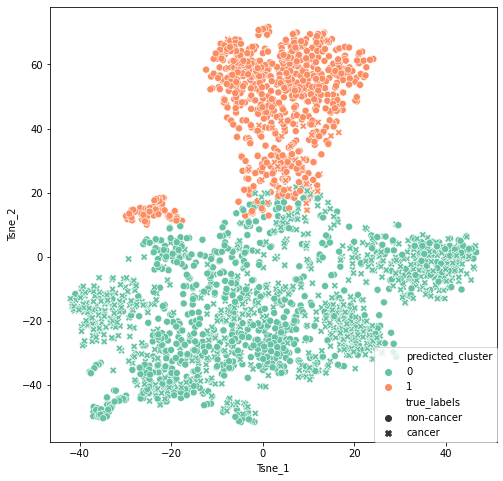

In [76]:
plt.figure(figsize=(8,8))

scat = sns.scatterplot(
     x="Tsne_1",
     y="Tsne_2",
     s=50,
     data=umapdf,
     hue="predicted_cluster",
     style="true_labels",
     palette="Set2",
)

plt.legend(loc=4, borderaxespad=0.0)

plt.savefig(f'{model_path}_clusterres_tsne_mask.png')
    

In [20]:
#kmeans_kwargs = {
#     "init": "random",
#     "n_init": 10,
#     "max_iter": 300,
#     "random_state": 42,
# }

# A list holds the SSE values for each k
#sse = []
#for k in range(1, 11):
#    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#    kmeans.fit(features)
#    sse.append(kmeans.inertia_)

In [21]:
#plt.figure(figsize=(12,10))
#plt.plot(range(1,11), sse, 'bx-')
#plt.xticks(range(1,11))
#plt.xlabel('Number of clusters')
#plt.ylabel('SSE')
#plt.title(f'The Elbow Method showing the optimal k for {model_path} features')
#plt.savefig(f'{model_path}_ncluster_plot.png')
#plt.show()

In [22]:
#kl = KneeLocator(
#    range(1, 11), sse, curve="convex", direction="decreasing"
# )
#kl.elbow

In [23]:
 # A list holds the silhouette coefficients for each k
#silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
#for k in range(2, 11):
#    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#    kmeans.fit(features)
#    score = silhouette_score(features, kmeans.labels_)
#    silhouette_coefficients.append(score)

In [24]:
#plt.figure(figsize=(12,10))
#plt.plot(range(2,11), silhouette_coefficients, 'bx-')
#plt.xticks(range(2,11))
#plt.xlabel('Number of clusters')
#plt.ylabel('silhouette_coefficients')
#plt.title(f'The silhouette coefficients showing the optimal k for {model_path} features')
#plt.savefig(f'{model_path}_ncluster_slicoef_plot.png')
#plt.show()

In [79]:
df_dataset["clusterid"] = umapdf["predicted_cluster"]
df_dataset["Patient"] = [x.split("_")[0] for x in df_dataset["Pseudonym"]]
umapdf["Patient"] = df_dataset["Patient"]
umapdf["lbl"] = df_dataset["lbl"]
umapdf["lbl_mask"] = df_dataset["lbl_mask"]
umapdf["multi-class"] = df_dataset["most_prevalent_cancer"]

In [26]:
#df2=df_dataset.loc[df_dataset['clusterid'] == 0, ['Pseudonym', 'tile_id']]
#print(df2[:500])

In [81]:
umapdf.head(10)

,Umap_1,Umap_2,predicted_cluster,true_labels,Tsne_1,Tsne_2,Patient,lbl,lbl_mask,multi-class
0,8.306437,10.323900,1,non-cancer,2.166919,44.660393,IAA2LDX17,cancer,non-cancer,Classical_KRT7
1,10.007959,10.999136,1,non-cancer,-5.809719,63.441536,IAA2LDX17,cancer,non-cancer,Classical_CEACAM
2,10.053314,10.985888,1,non-cancer,-5.501913,61.582729,IAA2LDX17,cancer,non-cancer,Classical_CEACAM
3,8.233452,11.022655,1,non-cancer,-1.292020,45.779221,IAA2LDX17,cancer,non-cancer,Classical_CEACAM
4,9.867911,10.263768,1,non-cancer,6.829758,67.941452,1C73PUTH4,cancer,non-cancer,Basal
5,9.325489,9.996898,1,non-cancer,4.040119,65.943474,1C73PUTH4,cancer,non-cancer,Basal
6,8.944137,9.196153,1,non-cancer,15.455859,50.639477,IJ324DWM3,non-cancer,non-cancer,non-cancer
7,8.752538,9.999958,1,non-cancer,-7.796030,46.598473,1C73PUTH4,cancer,non-cancer,Classical_CEACAM
8,9.274823,9.883413,1,non-cancer,15.297390,56.929379,1C73PUTH4,non-cancer,non-cancer,non-cancer
9,9.027527,9.360960,1,non-cancer,14.623592,58.890659,1C73PUTH4,cancer,non-cancer,Basal


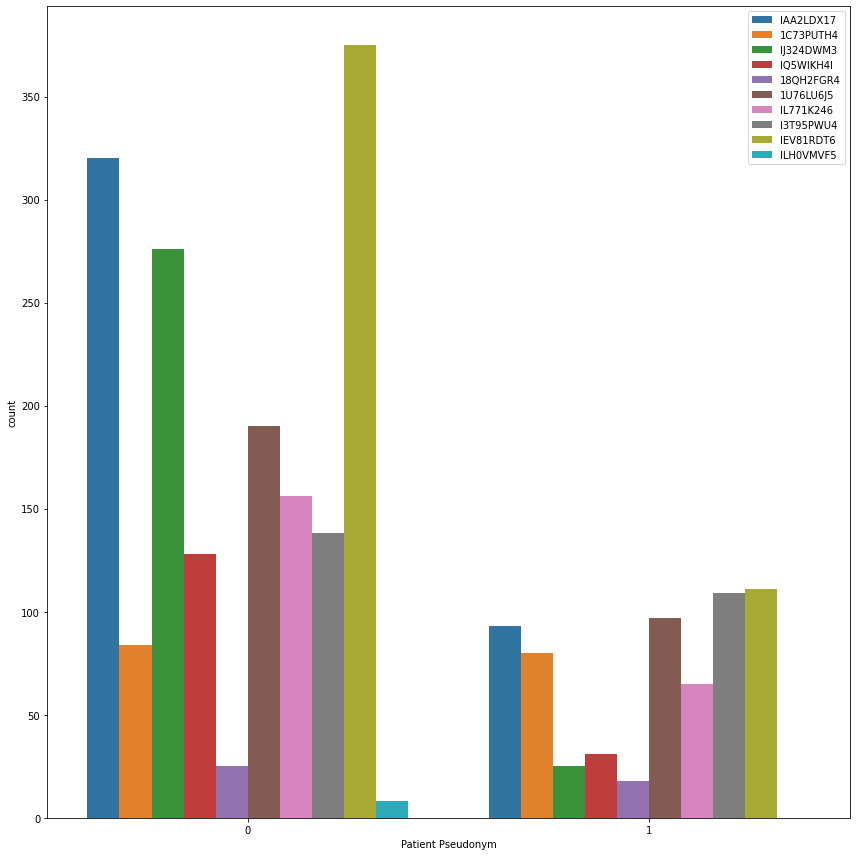

In [16]:
fig = plt.figure(figsize=(12, 12))
sns.countplot(data=umapdf, hue='Patient', x='predicted_cluster')
plt.xlabel('Patient Pseudonym')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(f'countplot_{model_path}_feaftures_Patient_clusterid_multi.png', dpi=400)
plt.show()

     lbl_mask  predicted_cluster   percent
0      cancer                  0  0.947696
1      cancer                  1  0.052304
2  non-cancer                  0  0.549803
3  non-cancer                  1  0.450197


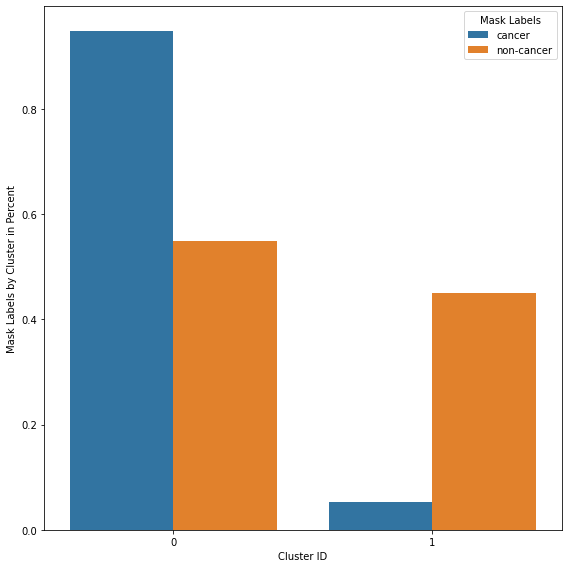

In [82]:
df_percents=umapdf.groupby("lbl_mask")["predicted_cluster"].value_counts(normalize=True).rename('percent').reset_index()
print(df_percents)
fig = plt.figure(figsize=(8, 8))
sns.barplot(data=df_percents.sort_values(by="lbl_mask"), x='predicted_cluster', hue='lbl_mask', y='percent')
plt.xlabel('Cluster ID')
plt.ylabel("Mask Labels by Cluster in Percent")
plt.legend(loc="upper right", title="Mask Labels")
plt.tight_layout()
plt.savefig(f'countplot_{model_path}_feaftures_mask_clusterid.png', dpi=400)
plt.show()

          lbl  predicted_cluster   percent
0      cancer                  0  0.702083
1      cancer                  1  0.297917
2  non-cancer                  0  0.737155
3  non-cancer                  1  0.262845


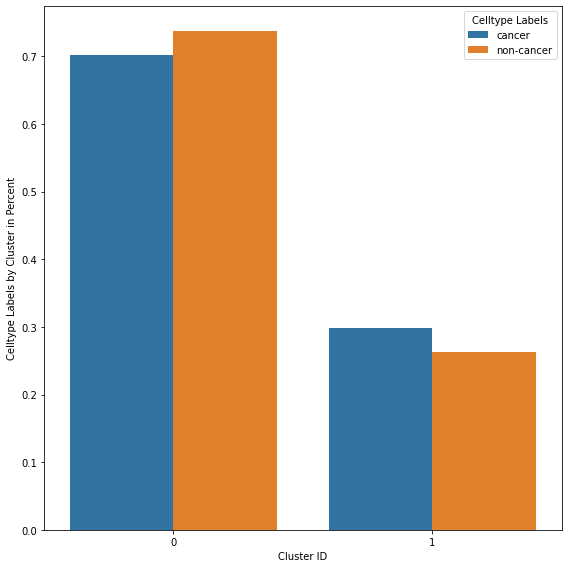

In [55]:
df_percents=umapdf.groupby("lbl")["predicted_cluster"].value_counts(normalize=True).rename('percent').reset_index()
print(df_percents)
fig = plt.figure(figsize=(8, 8))
sns.barplot(data=df_percents.sort_values(by="lbl"), hue='lbl', x='predicted_cluster', y='percent')
plt.xlabel('Cluster ID')
plt.ylabel("Celltype Labels by Cluster in Percent")
plt.legend(loc="upper right", title="Celltype Labels")
plt.tight_layout()
plt.savefig(f'countplot_{model_path}_feaftures_lbl_clusterid.png', dpi=400)
plt.show()

         multi-class  predicted_cluster   percent
0              Basal                  1  0.244898
1              Basal                  2  0.204082
2              Basal                  4  0.183673
3              Basal                  3  0.163265
4              Basal                  0  0.122449
5              Basal                  5  0.081633
6   Classical_CEACAM                  3  0.518519
7   Classical_CEACAM                  0  0.222222
8   Classical_CEACAM                  1  0.155556
9   Classical_CEACAM                  4  0.051852
10  Classical_CEACAM                  2  0.044444
11  Classical_CEACAM                  5  0.007407
12    Classical_KRT7                  1  0.318681
13    Classical_KRT7                  5  0.241758
14    Classical_KRT7                  0  0.153846
15    Classical_KRT7                  3  0.120879
16    Classical_KRT7                  2  0.109890
17    Classical_KRT7                  4  0.054945
18    Classical_REG4                  1  0.750000


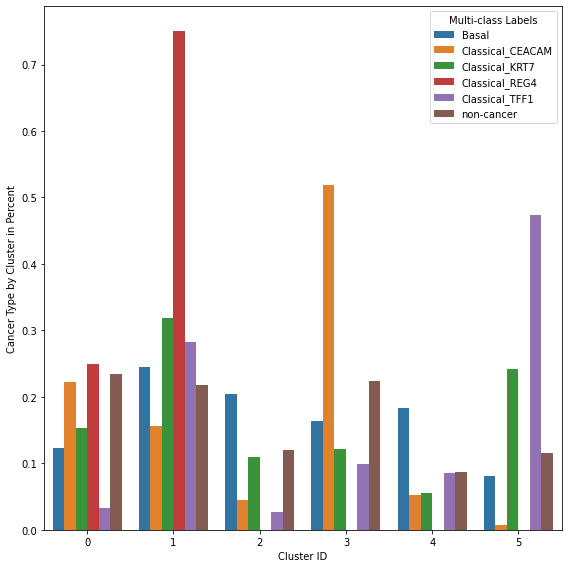

In [60]:
df_percents=umapdf.groupby("multi-class")["predicted_cluster"].value_counts(normalize=True).rename('percent').reset_index()
print(df_percents)
fig = plt.figure(figsize=(8, 8))
sns.barplot(data=df_percents.sort_values(by="multi-class"), hue='multi-class', x='predicted_cluster', y="percent")
#plt.xlabel('Multi-class Labels')
plt.xlabel('Cluster ID')
plt.ylabel("Cancer Type by Cluster in Percent")
plt.legend(loc="upper right", title="Multi-class Labels")
plt.tight_layout()
plt.savefig(f'countplot_{model_path}_multi_clusterid.png', dpi=400)
plt.show()

In [83]:
write_pickle(path=os.path.join(base_path, clustering_path, method_path, model_path, f"{method_path}_{model_path}_clustering_df_masks.pkl"), obj=umapdf)